# Assignment 2: Feedforward Neural Networks

## Programming Question 1: Implementing Deep FNN
Through this assignment you learn how to use `torch.nn` module of torch to implement a neural network in only few lines of code.

We first import all required packages.

In [12]:
%pip install torch torchvision scikit-learn numpy matplotlib tqdm

Note: you may need to restart the kernel to use updated packages.


In [13]:
# We import torch and the nn module
import torch
import torch.nn as nn

# We import NumPy and tqdm
import numpy as np
from tqdm import tqdm

# We need few items from Scikit-Learn
import sklearn.datasets as DataSets
from sklearn.model_selection import train_test_split

# Also we need to plot few curves
import matplotlib.pyplot as plt

### Data Splitting: Make Training Mini-Batches

In [14]:
dataset = DataSets.make_classification(n_samples = 10000
                                       , n_features = 20
                                       , n_informative=5
                                       , n_redundant=15
                                       , random_state=1)
X, v = dataset

Below you can implement the function

In [15]:
def data_splitter(X, v, batch_size, train_size):
    '''
    X is list of data-points
    v is list of labels
    train_size is the fraction of data-points used for training
    '''
    X_train, X_test, v_train, v_test = train_test_split(X, v
        , train_size= train_size
        , shuffle = True
        )
    X_train = torch.tensor(X_train,dtype=torch.float32)
    v_train = torch.tensor(v_train,dtype=torch.float32).reshape(-1,1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    v_test = torch.tensor(v_test, dtype=torch.float32).reshape(-1, 1)
    batch_indx = torch.arange(0, len(X_train), batch_size)
    return X_train, v_train, X_test, v_test, batch_indx

### Basic Classes

For this task you can use `nn.Layer()`. You mainly need to complete the following `class`.

In [16]:
class myClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Linear(20, 64)
        self.active1 = nn.ReLU()

        self.layer2 = nn.Linear(64, 32)
        self.active2 = nn.ReLU()

        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.active1(self.layer1(x))
        x = self.active2(self.layer2(x))
        x = self.sigmoid(self.output(x))
        return x

### Backpropagation
We now learn how we can use the autograd of PyTorch to implement backpropagation. Simply complete the following code and run it to see how autograd works.

In [17]:
# first, instantiate the model 
myModel = myClassifier()

# now, define the loss
loss_fn = nn.BCELoss()

# split the dataset via function data_splitter()
X_train, v_train, X_test, v_test, batch_indx = data_splitter(X, v, batch_size=32, train_size=0.8)

# take a sample point from training dataset
x, v =  X_train[0], v_train[0]

# forward pass
y = myModel.forward(x)
Loss = loss_fn(y, v)

# backward pass
Loss.backward()

We can now access the computed gradient of the loss with respect to the output bias using the following code.

In [18]:
myModel.output.bias.grad

tensor([-0.4596])

### Optimizer
We can further define the optimizer for our model as follows:

In [19]:
# first, instantiate the model 
myModel = myClassifier()

# now define the optimizer
optimizer = torch.optim.Adam(myModel.parameters(),
                        lr=0.0001 # this specifies the learning rate
                        )

### Implementing Training and Test Loop
Now that we have all the components, we can simply implement the training loop. Complete the following code to get the training done.

In [20]:
def training_loop(model):
    # define the loss and optimizer
    loss_fn = nn.BCELoss() # binary cross-entropy
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # set the training parameters
    n_epochs = 300   # number of epochs
    batch_size = 40  # batch size

    # specify training and test datasets and the batch indices
    # use data_splitter() and X, v are generated by Scikit-Learn
    X_train, v_train, X_test, v_test, batch_indx = data_splitter(X, dataset[1], batch_size, train_size=0.8)

    # make empty list to save training and test risk
    train_risk = []
    test_risk = []

    # training loop

    # we visualize the training progress via tqdm
    with tqdm(range(n_epochs), unit="epoch") as epoch_bar:
        epoch_bar.set_description("training loop")
        for epoch in epoch_bar:

            # tell pytorch that you start training
            model.train()

            for indx in batch_indx:
                # take a batch of samples
                X_batch = X_train[indx:indx+batch_size]
                v_batch = v_train[indx:indx+batch_size]

                # pass forward the mini-batch
                y_batch = model(X_batch)

                # compute the loss
                loss = loss_fn(y_batch, v_batch)

                # backward pass
                # first make gradient zero
                optimizer.zero_grad()
                # then, compute the gradient of loss
                loss.backward()

                # now update weights by one optimization step
                optimizer.step()

            # we are done with one epoch
            # we now evaluate training and test risks
            # first we tell pytorch we are doing evaluation
            model.eval()

            # now we evaluate the training risk
            y_train = model(X_train)
            CE_train = loss_fn(y_train, v_train)
            train_risk.append(CE_train.item())

            # then we evaluate the test risk
            y_test = model(X_test)
            CE_test = loss_fn(y_test, v_test)
            test_risk.append(CE_test.item())
        return train_risk, test_risk

We can now try training our model by passing the model to the training loop. Complete the following code to train the model and plot the learning curves.

training loop: 100%|██████████| 300/300 [00:29<00:00, 10.07epoch/s]


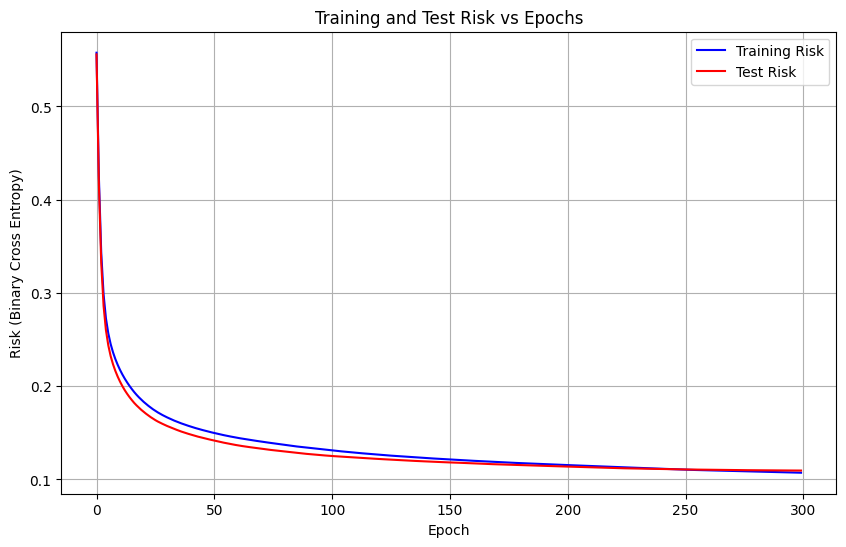

In [21]:
myModel = myClassifier()
train_risk, test_risk = training_loop(myModel)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(train_risk, label='Training Risk', color='blue')
plt.plot(test_risk, label='Test Risk', color='red')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Risk (Binary Cross Entropy)')
plt.title('Training and Test Risk vs Epochs')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

## Programming Question 2: MNIST Dataset
We play around a bit with the datasets in PyTorch.

In [31]:
import torch
import torchvision.datasets as DS
import torchvision.transforms as transform

Import the MNIST dataset by running the code below. 

In [23]:
mnist = DS.MNIST('./data',train=True,transform=transform.ToTensor(),download=True)

We now build a function `myBatcher()` which gets the batch size as the input and returns a list containing multiple batches. 

In [25]:
def myBatcher(batch_size):
    batch_list = []
    num_batches = len(mnist) // batch_size
    
    for j in range(num_batches):
        batch_x = torch.zeros(batch_size,784)
        batch_v = torch.zeros(batch_size)
        for i in range(batch_size):
            batch_x[i] = mnist[j * batch_size + i][0].reshape(-1)
            batch_v[i] = mnist[j * batch_size + i][1]
            
        batch = (batch_x,batch_v)
        batch_list.append(batch)
    return batch_list

Let's try the implemented function

In [30]:
batch_list = myBatcher(100)

first_batch_labels = batch_list[0][1]
third_batch_labels = batch_list[2][1]

# Print labels of first and third mini-batches
print(f"\nFirst mini-batch labels (batch 0):\n{first_batch_labels}")
print(f"\nThird mini-batch labels (batch 2):\n{third_batch_labels}")


First mini-batch labels (batch 0):
tensor([5., 0., 4., 1., 9., 2., 1., 3., 1., 4., 3., 5., 3., 6., 1., 7., 2., 8.,
        6., 9., 4., 0., 9., 1., 1., 2., 4., 3., 2., 7., 3., 8., 6., 9., 0., 5.,
        6., 0., 7., 6., 1., 8., 7., 9., 3., 9., 8., 5., 9., 3., 3., 0., 7., 4.,
        9., 8., 0., 9., 4., 1., 4., 4., 6., 0., 4., 5., 6., 1., 0., 0., 1., 7.,
        1., 6., 3., 0., 2., 1., 1., 7., 9., 0., 2., 6., 7., 8., 3., 9., 0., 4.,
        6., 7., 4., 6., 8., 0., 7., 8., 3., 1.])

Third mini-batch labels (batch 2):
tensor([1., 1., 8., 3., 6., 1., 0., 3., 1., 0., 0., 1., 7., 2., 7., 3., 0., 4.,
        6., 5., 2., 6., 4., 7., 1., 8., 9., 9., 3., 0., 7., 1., 0., 2., 0., 3.,
        5., 4., 6., 5., 8., 6., 3., 7., 5., 8., 0., 9., 1., 0., 3., 1., 2., 2.,
        3., 3., 6., 4., 7., 5., 0., 6., 2., 7., 9., 8., 5., 9., 2., 1., 1., 4.,
        4., 5., 6., 4., 1., 2., 5., 3., 9., 3., 9., 0., 5., 9., 6., 5., 7., 4.,
        1., 3., 4., 0., 4., 8., 0., 4., 3., 6.])
